In [343]:
!pip install gymnasium matplotlib numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [344]:
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import trange, tqdm
plt.rcParams['figure.figsize'] = (5, 17)

In [345]:
#Environment Requirements for both deterministic and Stochastic
class GridEnvironment(gym.Env):
  metadata = { 'render.modes': []}

  def __init__(self, stochastic = False, max_timesteps = 10):
    '''
    # Initializes the class
    # Define action and observation space
    #We have an action space of 4 Discrete actions, namely,
      1. Up, action = 0
      2. Down, action = 1
      3. Right, action = 2
      4. Left, action = 3
    #We have an observation space of 16, 4x4 grid hence the no of states is 16  (minimun was 12)
    The environment has 3 bonus positions as well as 2 hole/pit positions 
    # the numbers 1 and 0.5 for the state position are for visualizations
    #
    '''
    self.observation_space = spaces.Discrete(16)
    self.action_space = spaces.Discrete(4)
    self.max_timesteps = max_timesteps
    self.stochastic = stochastic
    self.agent_pos = [0, 0]
    self.goal_pos = [3, 3]
    self.hole1_pos = [1,3]
    self.hole2_pos = [2,2]
    self.bonus1_pos = [0,3]
    self.bonus2_pos = [1,2]
    self.bonus3_pos = [2,3]
    self.timestep = 0
    self.state = np.zeros((4,4))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[tuple(self.hole1_pos)] = 0.75
    self.state[tuple(self.hole2_pos)] = 0.75
    self.state[tuple(self.bonus1_pos)] = 0.25
    self.state[tuple(self.bonus2_pos)] = 0.25
    self.state[tuple(self.bonus3_pos)] = 0.25
  def reset(self, **kwargs):
    '''
    Reset the environment to initial state.

    '''
    self.timestep = 0
    self.agent_pos = [0, 0]
    self.goal_pos = [3, 3]
    self.hole1_pos = [1,3]
    self.hole2_pos = [2,2]
    self.bonus1_pos = [0,3]
    self.bonus2_pos = [1,2]
    self.bonus3_pos = [2,3]
    self.state = np.zeros((4, 4))
    self.pos_dict = {}
    for i in range(4):
      for j in range(4):
        self.pos_dict[4*i+j] = [i,j]
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.hole1_pos)] = 0.75
    self.state[tuple(self.hole2_pos)] = 0.75
    self.state[tuple(self.bonus1_pos)] = 0.25
    self.state[tuple(self.bonus2_pos)] = 0.25
    self.state[tuple(self.bonus3_pos)] = 0.25
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.agent_pos
    info = {}
    return observation,info


  def render(self):
    '''
    Render the GridEnvironment
    '''
    plt.imshow(self.state)
  
  
  def step(self, action):
    '''
    Define an execution of one timestep within the environment
    input :action: action from the action space [0,1,2,3]
    outputs :observation, reward, terminated, truncated, info
    '''
    info = {}
    reward=0
    old_pos = self.agent_pos
    old_dist = np.sqrt(np.sum(np.square(np.array(old_pos)-np.array(self.goal_pos))))

    # It adds a level of uncertainity to the environment
    if(self.stochastic):
      info['action_given'] = action
      if (np.random.uniform(0,1)>0.75):
        action = action
      else:
        action = self.action_space.sample()
      info['action_taken'] = action

    if action == 0:
      self.agent_pos[0] += 1
    if action == 1:
      self.agent_pos[0] -= 1
    if action == 2:
      self.agent_pos[1] += 1
    if action == 3:
      self.agent_pos[1] -= 1
    
    a,b= np.clip(self.agent_pos[0], 0, 3), np.clip(self.agent_pos[1], 0, 3)
    if a!=self.agent_pos[0]:
      reward-=1
    if b!=self.agent_pos[1]:
      reward-=1
    self.agent_pos[0] = a
    self.agent_pos[1] = b
    self.agent_pos = np.array(self.agent_pos)

    self.state = np.zeros((4,4))
    self.state[tuple(self.bonus1_pos)] = 0.25
    self.state[tuple(self.bonus2_pos)] = 0.25
    self.state[tuple(self.bonus3_pos)] = 0.25
    self.state[tuple(self.hole1_pos)] = 0.75
    self.state[tuple(self.hole2_pos)] = 0.75
    self.state[tuple(self.goal_pos)] = 0.5
    self.state[tuple(self.agent_pos)] = 1


    observation = self.state.flatten()
    
    new_dist = np.sqrt(np.sum(np.square(np.array(self.agent_pos)-np.array(self.goal_pos))))
    
    proximity = True
    if (old_dist-new_dist<0):
      reward = -1
      proximity = False
    elif (old_dist-new_dist==0):
      reward = 0
    else:
      reward = +1

    if (self.agent_pos == self.goal_pos).all():
      reward+= 10 
      self.state[tuple(self.goal_pos)]=self.state[tuple(self.agent_pos)]
    elif (self.agent_pos == self.bonus2_pos).all() and proximity:
      reward+=5 
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.50):
          reward+=2
      self.state[tuple(self.bonus2_pos)]=self.state[tuple(self.agent_pos)]
    elif (self.agent_pos == self.bonus3_pos).all() and proximity:
      reward+=5 
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.50):
          reward+=2
      self.state[tuple(self.bonus3_pos)]=self.state[tuple(self.agent_pos)]
    elif(self.agent_pos == self.hole2_pos).all():
      reward-=5 
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.9):
          reward-=3
      self.state[tuple(self.hole2_pos)]=self.state[tuple(self.agent_pos)]
    elif (self.agent_pos == self.bonus1_pos).all() and proximity:
      reward+=5 
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.50):
          reward+=2
      self.state[tuple(self.bonus1_pos)]=self.state[tuple(self.agent_pos)]
    elif (self.agent_pos == self.hole1_pos).all():
      reward-=5
      if(self.stochastic):
        if(np.random.uniform(0,1)<0.75):
          reward-=3
      self.state[tuple(self.hole1_pos)]=self.state[tuple(self.agent_pos)]
   
    observation = self.agent_pos

    self.timestep += 1
    terminated = True if ((self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all()) else False
    truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 3)) else False

    return observation, reward, terminated, truncated, info



([0, 0], {})


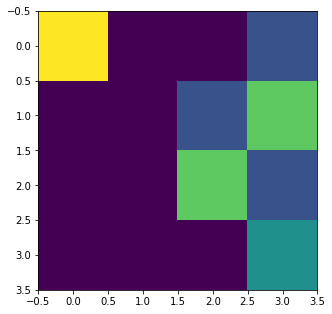

In [346]:
#DETERMISTIC environment - run a random agent for atleast 10 timesteps
deterenv = GridEnvironment(max_timesteps = 15)
observation = deterenv.reset()
print(observation)
deterenv.render()

In [347]:
#Initializing a Random Agent
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs):
    return np.random.choice(self.action_space.n)

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

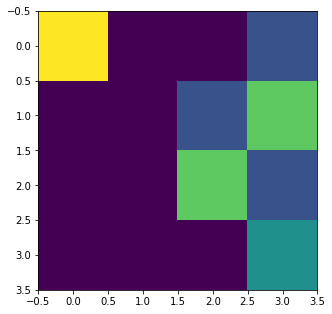

<IPython.core.display.Javascript object>

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 0, Action taken: 3, Terminated: False


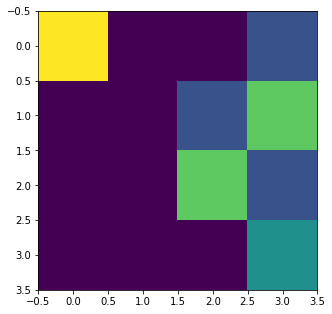

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 0, Action taken: 1, Terminated: False


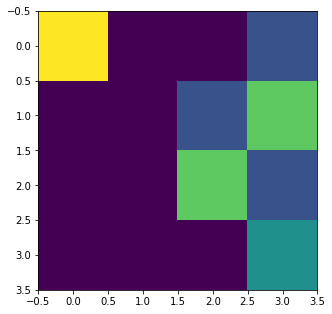

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 1, Action taken: 2, Terminated: False


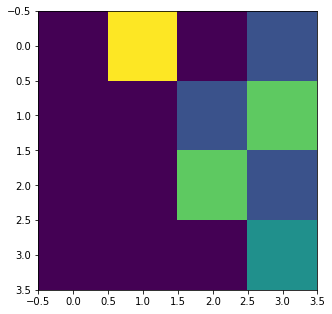

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: -1, Action taken: 3, Terminated: False


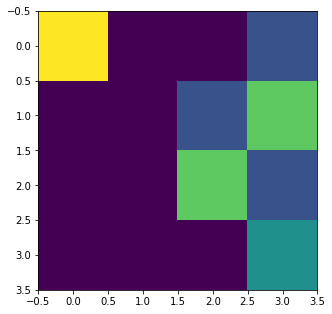

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 1, Action taken: 2, Terminated: False


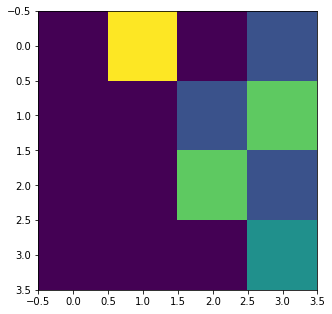

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: -1, Action taken: 3, Terminated: False


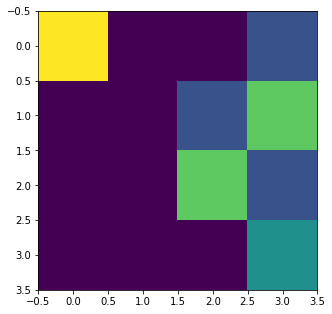

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 0, Action taken: 3, Terminated: False


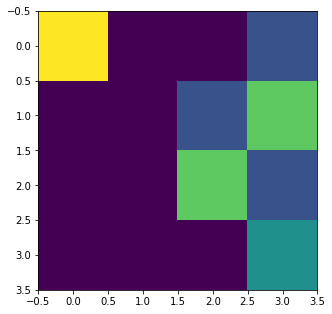

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 0, Action taken: 3, Terminated: False


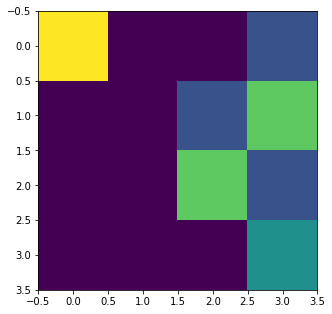

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 1, Action taken: 0, Terminated: False


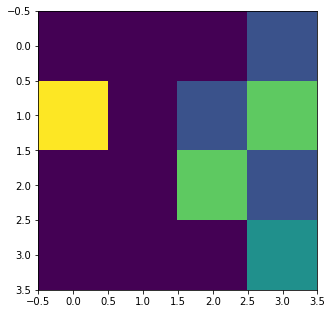

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 0, Action taken: 3, Terminated: False


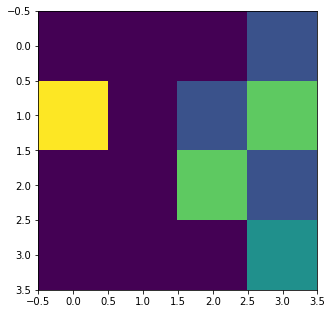

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: -1, Action taken: 1, Terminated: False


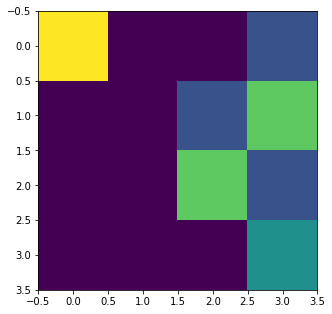

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 0, Action taken: 3, Terminated: False


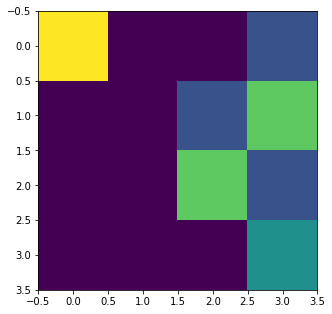

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 0, Action taken: 3, Terminated: False


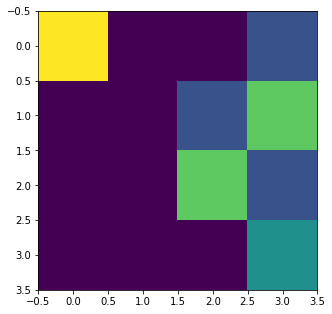

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 0, Action taken: 1, Terminated: False


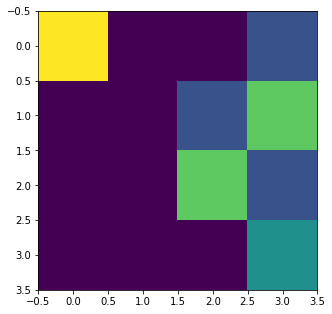

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 0, Action taken: 3, Terminated: True


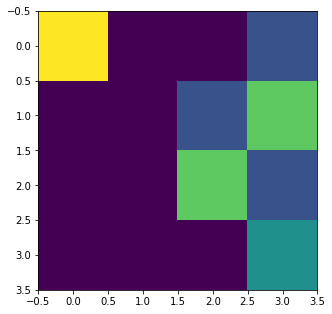

<IPython.core.display.Javascript object>

actions_given [3, 1, 2, 3, 2, 3, 3, 3, 0, 3, 1, 3, 3, 1, 3]
rewards [0, 0, 1, -1, 1, -1, 0, 0, 1, 0, -1, 0, 0, 0, 0]
cumulative reward 0


In [348]:
#Deterministic Environment
det_agent= RandomAgent(env= deterenv)
det_observation= deterenv.reset()
terminated = False

det_output_grid= widgets.Grid(1, 1)

# Test render of environment within widget grid
with det_output_grid.output_to(0, 0):
  deterenv.render()

actions_given = []
rewards = []
observations = []

output_grid = widgets.Grid(1,1)

# MDP loop
while not terminated:
  action= det_agent.step(det_observation)

  observation, reward, terminated, truncated, info= deterenv.step(action)
  actions_given.append(action)
  rewards.append(reward)
  observations.append(observation)
  with output_grid.output_to(0,0):
    deterenv.render()
    print(f'Reward: {reward}, Action taken: {action}, Terminated: {terminated}')
  time.sleep(1)
print("actions_given", actions_given)
print("rewards", rewards)
print("cumulative reward",sum(rewards))
     


([0, 0], {})


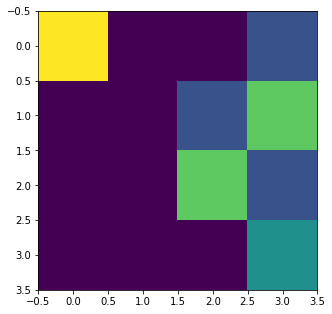

In [349]:
stocenv = GridEnvironment(stochastic=True,max_timesteps = 15)
observation = stocenv.reset()
print(observation)
stocenv.render()

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

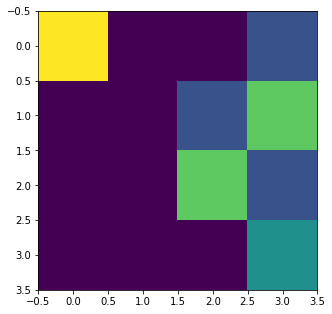

<IPython.core.display.Javascript object>

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 1, Action taken: 2, Terminated: False
{'action_given': 2, 'action_taken': 2}


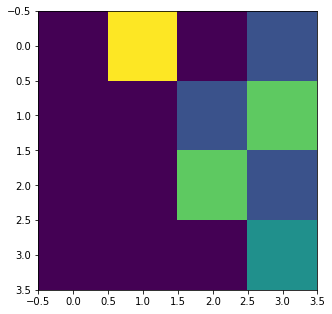

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 1, Action taken: 3, Terminated: False
{'action_given': 3, 'action_taken': 0}


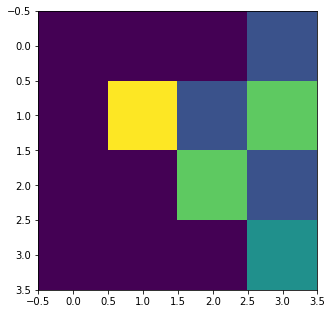

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 1, Action taken: 0, Terminated: False
{'action_given': 0, 'action_taken': 0}


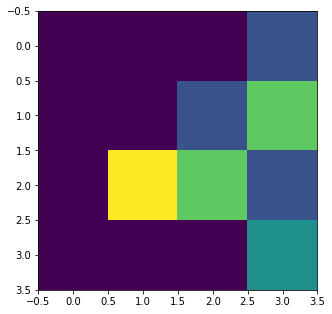

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: -1, Action taken: 1, Terminated: False
{'action_given': 1, 'action_taken': 1}


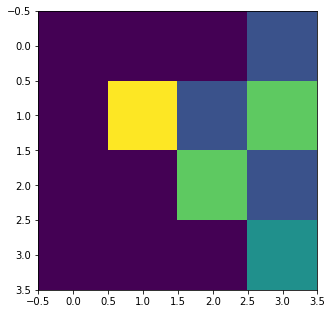

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 8, Action taken: 1, Terminated: False
{'action_given': 1, 'action_taken': 2}


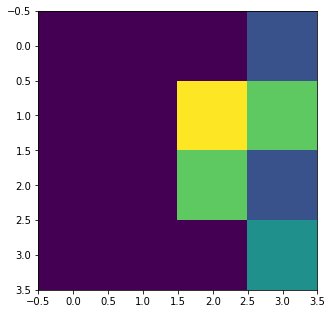

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: -7, Action taken: 2, Terminated: False
{'action_given': 2, 'action_taken': 0}


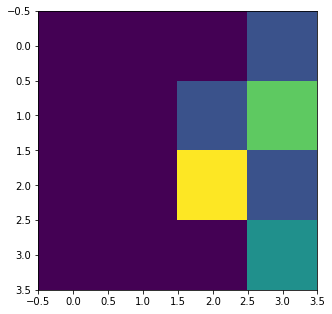

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 6, Action taken: 2, Terminated: False
{'action_given': 2, 'action_taken': 2}


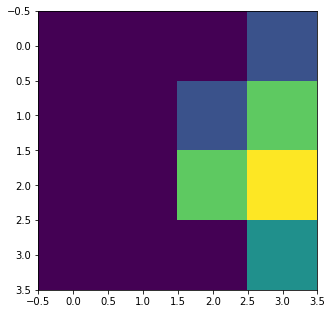

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: -9, Action taken: 2, Terminated: False
{'action_given': 2, 'action_taken': 3}


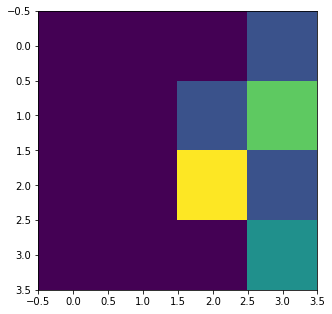

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 1, Action taken: 0, Terminated: False
{'action_given': 0, 'action_taken': 0}


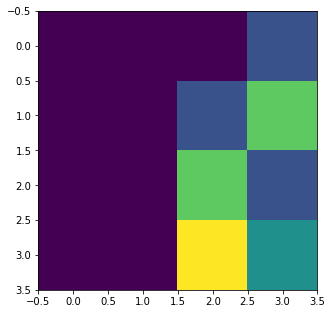

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: -9, Action taken: 1, Terminated: False
{'action_given': 1, 'action_taken': 1}


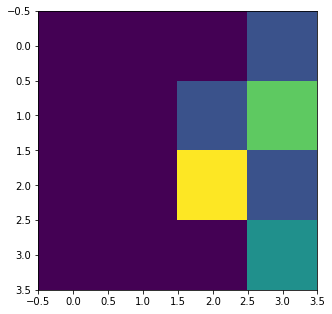

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 6, Action taken: 0, Terminated: False
{'action_given': 0, 'action_taken': 2}


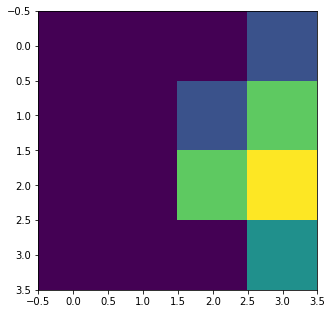

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reward: 11, Action taken: 3, Terminated: True
{'action_given': 3, 'action_taken': 0}


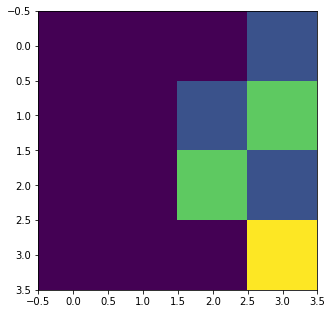

<IPython.core.display.Javascript object>

actions_given [2, 3, 0, 1, 1, 2, 2, 2, 0, 1, 0, 3]
rewards [1, 1, 1, -1, 8, -7, 6, -9, 1, -9, 6, 11]
cumulative reward 9


In [350]:
#Stochastic Environment
stoc_agent= RandomAgent(env= stocenv)
stoc_observation= stocenv.reset()
terminated = False

stoc_output_grid= widgets.Grid(1, 1)

# Test render of environment within widget grid
with stoc_output_grid.output_to(0, 0):
  stocenv.render()

actions_given = []
rewards = []
observations = []

output_grid = widgets.Grid(1,1)

# MDP loop
while not terminated:
  action= stoc_agent.step(stoc_observation)
  observation, reward, terminated, truncated, info= stocenv.step(action)
  actions_given.append(action)
  rewards.append(reward)
  observations.append(observation)
  with output_grid.output_to(0,0):
    stocenv.render()
    print(f'Reward: {reward}, Action taken: {action}, Terminated: {terminated}')
    print(info)
  time.sleep(1)
print("actions_given", actions_given)
print("rewards", rewards)
print("cumulative reward",sum(rewards))
     


In [351]:
class QLearning():
  def __init__(self,env):
    self.env = env
    # discrete object cannot be interpreted as an integer
    self.Q_table = np.zeros((env.observation_space.n,env.action_space.n))
    self.epsilon_min = 0.005 
    self.epsilon_decay = 0.995
  def fit(self, episodes, alpha, gamma, train = True):
    rewards_total = []
    epislon_array = []
    aggregate = {'ep': [], 'avg': [], 'max': [], 'min': [], 'ravg': [],'penalties': [], 'explore':[], 'exploit': []}
    #epsilon value is initially 1. you want to explore as much as you can. epsilon greedy algorithm
    epsilon = 1
    alpha = np.random.uniform(0.1,0.2)
    gamma = np.random.uniform(0.9,0.99)
    for episode in range(0,episodes):
      actions = []
      rewards_per_episode = []
      cumulative_reward = 0
      initial_state,info = self.env.reset()
      terminated = False
      if (not isinstance(initial_state, int)):
        idx = 4*(initial_state[0])+initial_state[1]
      else:
        idx = 0
      step = 1
      penalty = 0
      exploration,exploitation = 0,0
      while(terminated!=True):
        if (np.random.uniform(self.epsilon_min,1)>=epsilon) or (not train):
          # you are being greedy here. selecting the action which has the maximum value 
          exploitation+=1
          action = np.argmax(self.Q_table[idx])
        else:
          #since its high probability initially
          exploration+=1
          action = self.env.action_space.sample()
        observation, reward, terminated, truncated, info= self.env.step(action)
        #observation is the new state of the agent
        reward = (gamma**step)*reward
        cumulative_reward += reward
        if reward<0:
          penalty+=1
        rewards_per_episode.append(reward)
        if (not isinstance(initial_state, int)):
          new = 4*(observation[0])+observation[1]
        else:
          new = observation
        if train:
          maxx = np.argmax(self.Q_table[new])
          a= (1-alpha)*(self.Q_table[idx,action])
          b = (alpha) * (reward+ gamma*maxx)
          self.Q_table[idx,action] = a+b
        idx = new
        step+=1
        actions.append(action)
      aggregate['explore'].append(exploration)
      aggregate['exploit'].append(exploitation)
      aggregate['ep'].append(episode)
      aggregate['ravg'].append(sum(rewards_per_episode)/(episode+1))
      aggregate['max'].append(max(rewards_per_episode))
      aggregate['min'].append(min(rewards_per_episode))
      aggregate['avg'].append(cumulative_reward/episodes)
      rewards_total.append(cumulative_reward)
      epislon_array.append(epsilon)
      if (train) and (episode+1)%100 == 0:
        val = (penalty)/100
        aggregate['penalties'].append(val)
      if train:
        epsilon *= self.epsilon_decay
    return epislon_array, rewards_total, aggregate, alpha, gamma

gamma value:
0.9231952222602222
episodes
4834


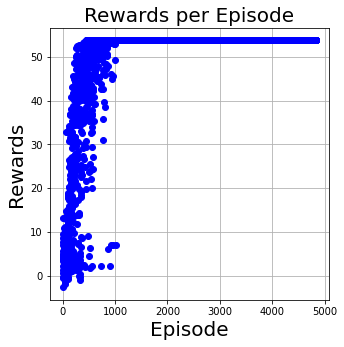

gamma value:
0.9459746779746496
episodes
2856


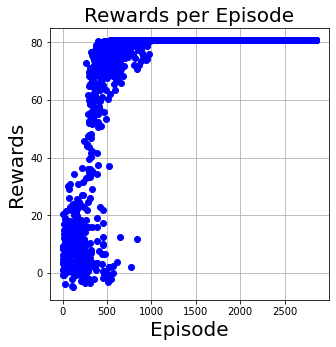

gamma value:
0.9707402222086229
episodes
3117


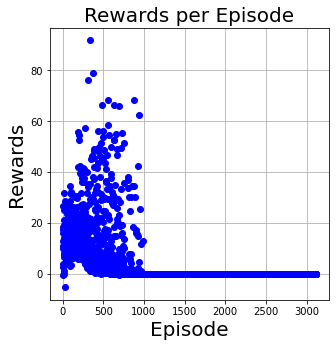

gamma value:
0.9832285176822193
episodes
3619


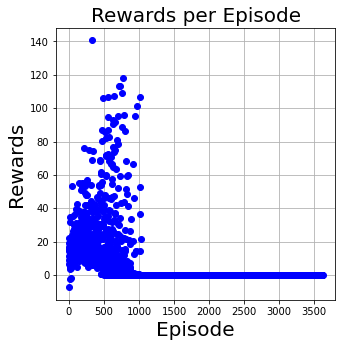

gamma value:
0.9075490108538025
episodes
2460


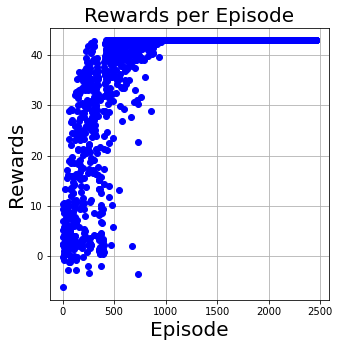

gamma value:
0.9778693265446885
episodes
3876


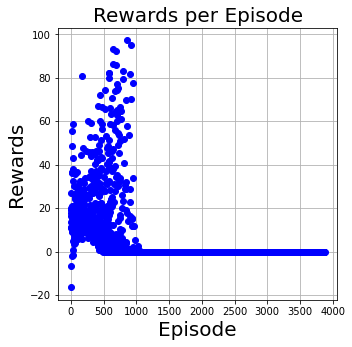

In [352]:
#Deterministic Environment
env = GridEnvironment(stochastic = False, max_timesteps = 100)
model = QLearning(env)
#Q_table update
for i in range(0,6):
  alpha = np.random.uniform(0.1,0.2)
  gamma = np.random.uniform(0.9,0.99)
  epsilon_array, reward_array , dict, alpha, gamma = model.fit(episodes=int(np.random.uniform(2000,5000)),alpha=alpha,gamma=gamma)
  print("gamma value:")
  print(gamma)
  print("episodes")
  print(len(dict['ep']))
  rewards1, episodes1 = reward_array, dict['ep']
  plt.rcParams['figure.figsize'] = (5, 5)
  plt.xlabel('Episode',fontsize=20)
  plt.ylabel('Rewards',fontsize=20)
  plt.title("Rewards per Episode",fontsize=20)
  plt.plot(episodes1, rewards1,"bo", label="total rewards per episode")
  plt.grid()
  plt.show()


In [353]:
#Picke download for Q learning table
values = model.Q_table
import pickle
with open('Q_table.pkl', 'wb') as f:
  pickle.dump(values, f)

Text(0, 0.5, 'Epsilon')

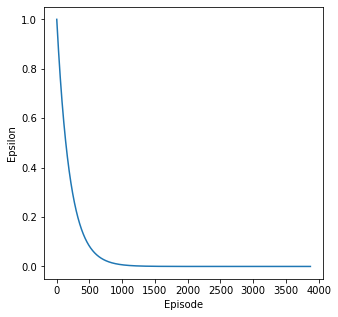

In [354]:
#Epsilon Decay Plot for Training
plt.rcParams['figure.figsize'] = (5, 5)
plt.plot(range(len(epsilon_array)), epsilon_array)
plt.xlabel('Episode')
plt.ylabel('Epsilon')

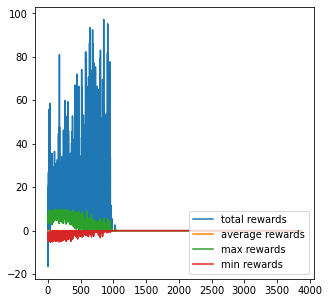

In [355]:
#Graphs for Total Rewards/Average Rewards/Max Rewards/ Min rewards for training
plt.plot(dict['ep'], reward_array  ,label="total rewards")
plt.plot(dict['ep'], dict['avg'],label="average rewards")
plt.plot(dict['ep'], dict['max'],label="max rewards")
plt.plot(dict['ep'], dict['min'],label="min rewards")
plt.legend(loc=4)
plt.show()

gamma value:
0.9495496424012938
episodes
200


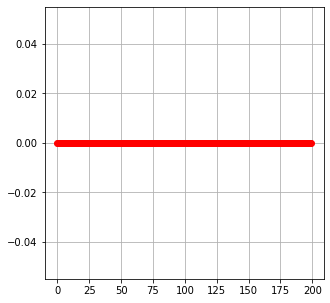

In [356]:
#Evaluation on my test environment
epsilon_array, reward_array , dict, alpha, gamma = model.fit(episodes=200, train=False,alpha=alpha,gamma=gamma)
print("gamma value:")
print(gamma)
print("episodes")
print(len(dict['ep']))
plt.plot(dict['ep'], reward_array, "ro")
plt.grid()
plt.show()

gamma value:
0.9811217394003995
episodes
4121


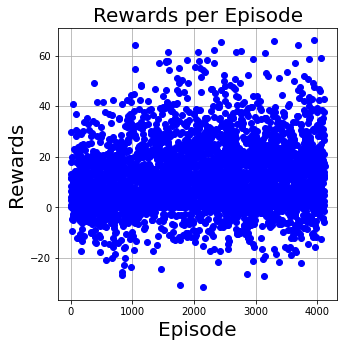

gamma value:
0.9110740139010869
episodes
4273


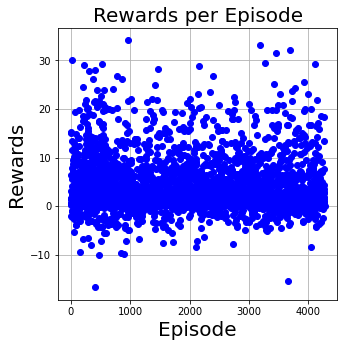

gamma value:
0.9388193927017815
episodes
4057


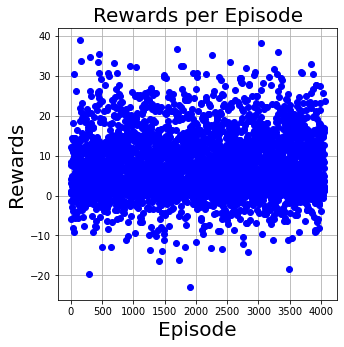

gamma value:
0.9116778750982627
episodes
4886


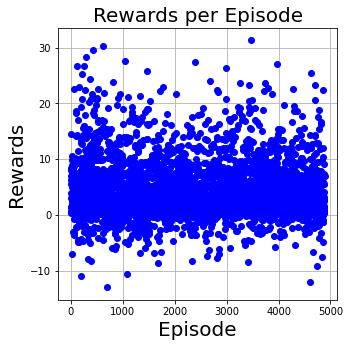

gamma value:
0.9076252560251412
episodes
4845


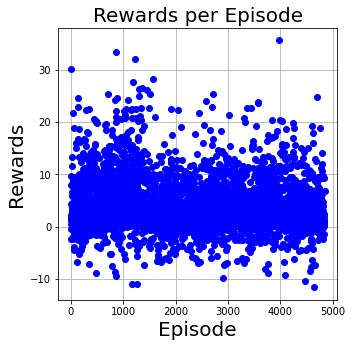

gamma value:
0.9374210716050936
episodes
3641


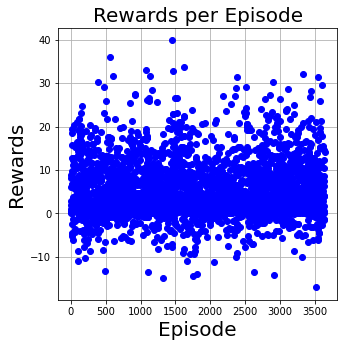

In [357]:
#Stochastic Environment
env = GridEnvironment(stochastic = True, max_timesteps = 15)
model = QLearning(env)
for i in range(0,6):
  alpha = np.random.uniform(0.1,0.2)
  gamma = np.random.uniform(0.9,0.99)
  epsilon_array, reward_array , dict, alpha, gamma = model.fit(episodes=int(np.random.uniform(3000,5000)),alpha=alpha,gamma=gamma)
  print("gamma value:")
  print(gamma)
  print("episodes")
  print(len(dict['ep']))
  rewards1, episodes1 = reward_array, dict['ep']
  plt.rcParams['figure.figsize'] = (5, 5)
  plt.xlabel('Episode',fontsize=20)
  plt.ylabel('Rewards',fontsize=20)
  plt.title("Rewards per Episode",fontsize=20)
  plt.plot(episodes1, rewards1,"bo", label="total rewards per episode")
  plt.grid()
  plt.show()

Text(0, 0.5, 'Epsilon')

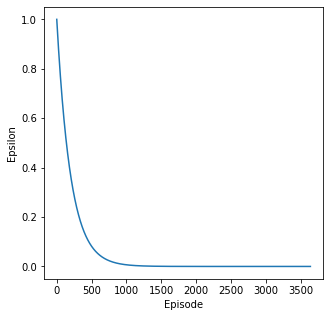

In [358]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.plot(range(len(epsilon_array)), epsilon_array)
plt.xlabel('Episode')
plt.ylabel('Epsilon')

In [359]:
values = model.Q_table
import pickle
with open('Q_table_Stochastic.pkl', 'wb') as f:
  pickle.dump(values, f)

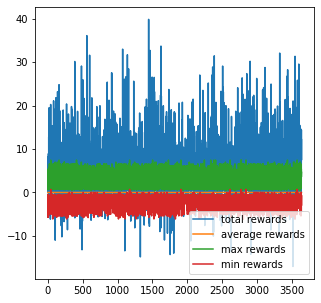

In [360]:
#Max Min Avg graph for Stochastic Environment
plt.rcParams['figure.figsize'] = (5, 5)
plt.plot(dict['ep'], reward_array , label="total rewards")
plt.plot(dict['ep'], dict['avg'], label="average rewards")
plt.plot(dict['ep'], dict['max'], label="max rewards")
plt.plot(dict['ep'], dict['min'], label="min rewards")
plt.legend(loc=4)
plt.show()

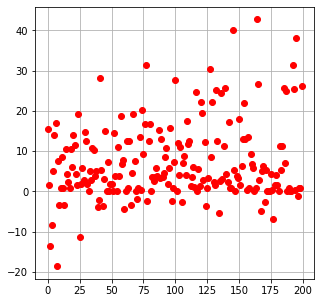

In [361]:
#Testing the learnt Q-Learning Algorithm on Stochastic Environment for the Grid World problem
epsilon_array, reward_array , dict, alpha, gamma = model.fit(episodes=200, train=False,alpha=alpha, gamma=gamma)
plt.plot(dict['ep'], reward_array, "ro")
plt.grid()
plt.show()

In [362]:
class DoubleQLearning():
  def __init__(self,env):
    self.env = env
    # discrete object cannot be interpreted as an integer
    self.Q_a = np.zeros((env.observation_space.n,env.action_space.n))
    self.Q_b = np.zeros((env.observation_space.n,env.action_space.n))
    self.epsilon_min = 0.005 
    self.epsilon_decay = 0.995
  def fit(self,episodes,alpha,gamma,train=True):
    epsilon = 1
    rewards_total = []
    epislon_array = []
    aggregate = {'ep': [], 'avg': [], 'max': [], 'min': [], 'ravg': [],'penalties': [], 'explore':[], 'exploit': []}
    if not alpha: alpha = np.random.uniform(0.1,0.2)
    if not gamma: gamma = np.random.uniform(0.9,0.99)
    # declare all the Q(s,a) arbitarily except the terminal state
    for episode in range(0,episodes):
      cumulative_reward = 0
      actions = []
      rewards_per_episode = []
      idx = 0
      terminated = False
      step = 1
      penalty = 0
      while(terminated!=True):
        if np.random.uniform(0,1)<=0.5:
          update = 1
        else:
          update = 0
        if update == 1:
          if (np.random.uniform(self.epsilon_min,1)>=epsilon) or (not train):
            action = np.argmax(self.Q_a[idx])
          else:
            action =  self.env.action_space.sample()
          observation, reward, terminated, truncated, info= self.env.step(action)
          new = 4*(observation[0]) + observation[1]
          if (train):
            a = (1-alpha)* (self.Q_a[idx,action])
            maxx = np.argmax(self.Q_a[new])
            b = alpha * (reward + gamma * self.Q_b[new,maxx])
            self.Q_a[idx,action] = a+b
        else:
          if (np.random.uniform(self.epsilon_min,1)>=epsilon) or (not train):
            action = np.argmax(self.Q_b[idx])
          else:
            action =  self.env.action_space.sample()
          observation, reward, terminated, truncated, info= self.env.step(action)
          new = 4*(observation[0]) + observation[1]
          if (train):
            a = (1-alpha)* (self.Q_b[idx,action])
            maxx = np.argmax(self.Q_b[new])
            b = alpha * (reward + gamma * self.Q_a[new,maxx])
            self.Q_b[idx,action] = a+b
        reward = (gamma**step)*reward 
        # discounted reward
        cumulative_reward += reward
        rewards_per_episode.append(reward)
        idx = new
        step+=1
      aggregate['ep'].append(episode)
      aggregate['max'].append(max(rewards_per_episode))
      aggregate['min'].append(min(rewards_per_episode))
      aggregate['avg'].append(cumulative_reward/episodes)
      aggregate['ravg'].append(sum(rewards_per_episode)/(episode+1))
      rewards_total.append(cumulative_reward)
      epislon_array.append(epsilon)
      if (train) and (episode+1)%100 == 0:
        val = (penalty)/100
        aggregate['penalties'].append(val)
      if train:
        epsilon *= self.epsilon_decay
    return epislon_array, rewards_total, aggregate,alpha, gamma

gamma value:
0.9767249706851862
episodes
3590


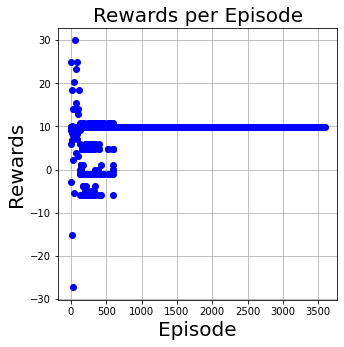

gamma value:
0.9327288879450156
episodes
3940


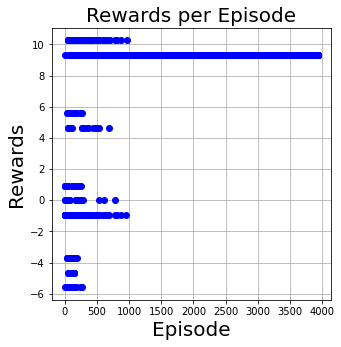

gamma value:
0.9036368712995658
episodes
4450


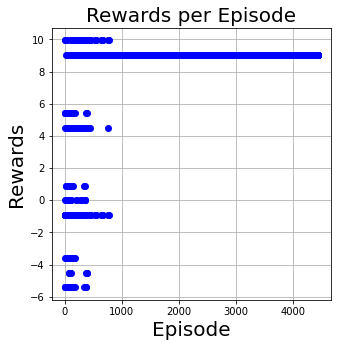

gamma value:
0.9764377504905651
episodes
3806


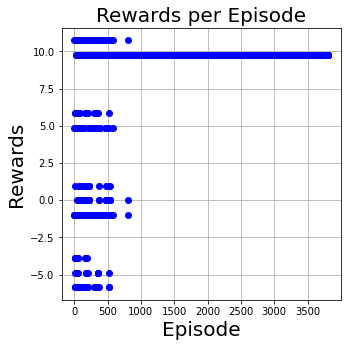

gamma value:
0.9116878930200092
episodes
4584


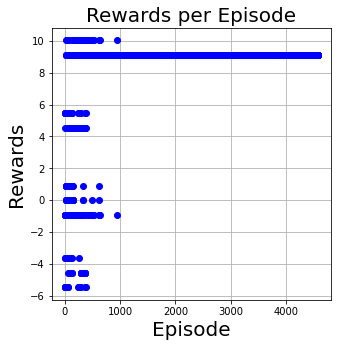

gamma value:
0.9039979177045565
episodes
4463


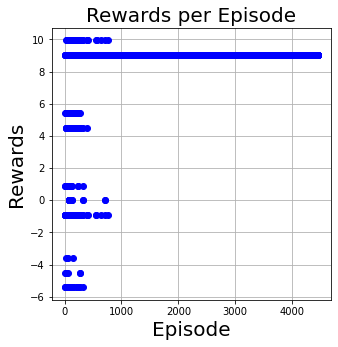

In [363]:
#Deterministic Environment
#Rewards vs Episodes graph for determinsitic Double Q learning
env = GridEnvironment(stochastic = False, max_timesteps = 1000)
model = DoubleQLearning(env)
for i in range(0,6):
  alpha = np.random.uniform(0.1,0.2)
  gamma = np.random.uniform(0.9,0.99)
  epsilon_array, reward_array , dict, alpha, gamma = model.fit(episodes=int(np.random.uniform(3000,5000)),alpha=alpha,gamma=gamma)
  print("gamma value:")
  print(gamma)
  print("episodes")
  print(len(dict['ep']))
  rewards1, episodes1 = reward_array, dict['ep']
  plt.rcParams['figure.figsize'] = (5, 5)
  plt.xlabel('Episode',fontsize=20)
  plt.ylabel('Rewards',fontsize=20)
  plt.title("Rewards per Episode",fontsize=20)
  plt.plot(episodes1, rewards1,"bo", label="total rewards per episode")
  plt.grid()
  plt.show()

In [364]:
#Picke download for Q learning table
values1 = model.Q_a
values2 = model.Q_b
import pickle
with open('Q_a.pkl', 'wb') as f:
  pickle.dump(values1, f)
with open('Q_b.pkl', 'wb') as f:
  pickle.dump(values2, f)

Text(0, 0.5, 'Epsilon')

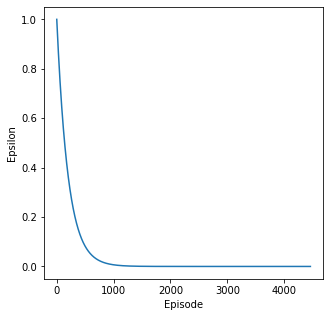

In [365]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.plot(range(len(epsilon_array)), epsilon_array)
plt.xlabel('Episode')
plt.ylabel('Epsilon')

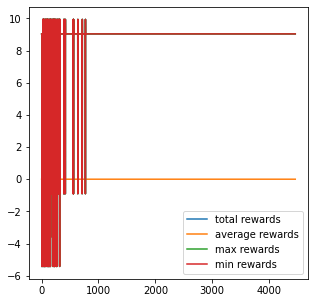

In [366]:
#Plotting total/max/min/avg rewards for the Deterministic Environment
plt.rcParams['figure.figsize'] = (5, 5)
plt.plot(dict['ep'], reward_array , label="total rewards")
plt.plot(dict['ep'], dict['avg'], label="average rewards")
plt.plot(dict['ep'], dict['max'], label="max rewards")
plt.plot(dict['ep'], dict['min'], label="min rewards")
plt.legend(loc=4)
plt.show()

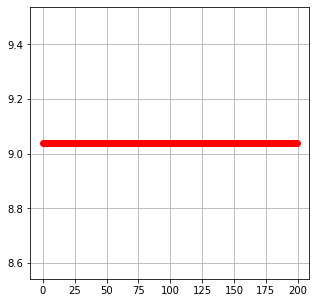

In [367]:
#Testing the learnt Q-Learning Algorithm on Stochastic Environment for the Grid World problem
epsilon_array, reward_array , dict, alpha, gamma = model.fit(episodes=200, train=False,alpha=alpha,gamma=gamma)
plt.plot(dict['ep'], reward_array, "ro")
plt.grid()
plt.show()

gamma value:
0.9432351491965787
episodes
3399


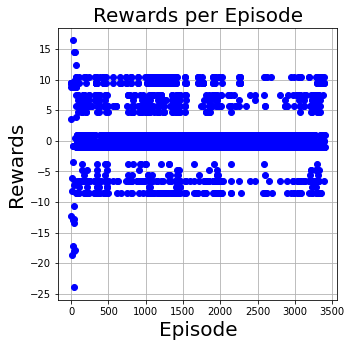

gamma value:
0.9664062164403934
episodes
4911


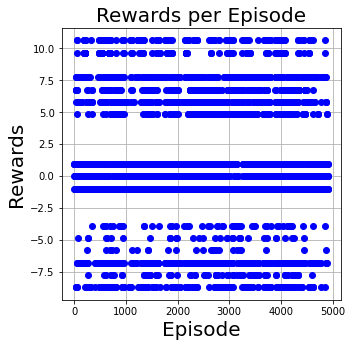

gamma value:
0.9551046892190272
episodes
3458


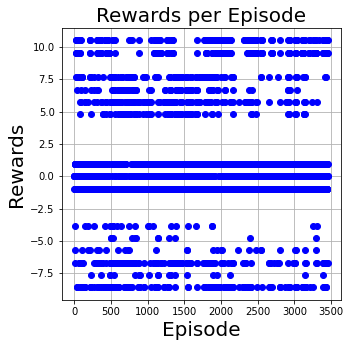

gamma value:
0.9412613286925708
episodes
4318


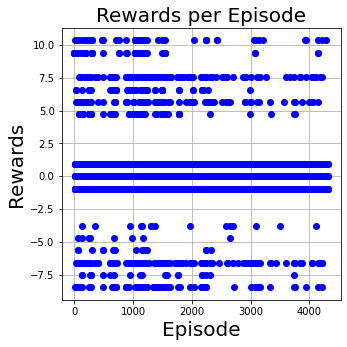

gamma value:
0.9151487193330008
episodes
4518


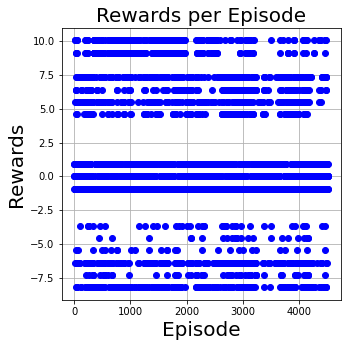

gamma value:
0.9709412430590216
episodes
4017


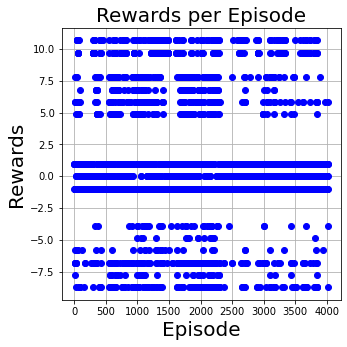

In [368]:
#Stochastic Environment
env = GridEnvironment(stochastic = True, max_timesteps = 1000)
model = DoubleQLearning(env)
for i in range(0,6):
  alpha = np.random.uniform(0.1,0.2)
  gamma = np.random.uniform(0.9,0.99)
  epsilon_array, reward_array , dict, alpha, gamma = model.fit(episodes=int(np.random.uniform(3000,5000)),alpha=alpha,gamma=gamma)
  print("gamma value:")
  print(gamma)
  print("episodes")
  print(len(dict['ep']))
  rewards1, episodes1 = reward_array, dict['ep']
  plt.rcParams['figure.figsize'] = (5, 5)
  plt.xlabel('Episode',fontsize=20)
  plt.ylabel('Rewards',fontsize=20)
  plt.title("Rewards per Episode",fontsize=20)
  plt.plot(episodes1, rewards1,"bo", label="total rewards per episode")
  plt.grid()
  plt.show()

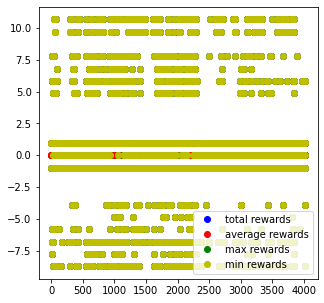

In [369]:
#Plotting total/max/min/avg rewards for the Stochastic Environment
plt.rcParams['figure.figsize'] = (5, 5)
plt.plot(dict['ep'], reward_array ,"bo", label="total rewards")
plt.plot(dict['ep'], dict['avg'], "ro",label="average rewards")
plt.plot(dict['ep'], dict['max'], "go",label="max rewards")
plt.plot(dict['ep'], dict['min'], "yo",label="min rewards")
plt.legend(loc=4)
plt.show()

Text(0, 0.5, 'Epsilon')

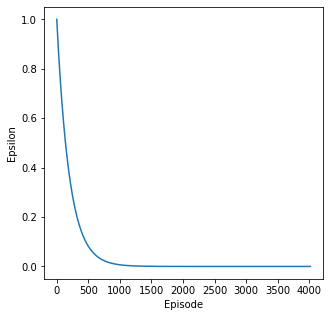

In [370]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.plot(range(len(epsilon_array)), epsilon_array)
plt.xlabel('Episode')
plt.ylabel('Epsilon')

In [371]:
#Picke download for Q learning table
values1 = model.Q_a
values2 = model.Q_b
import pickle
with open('Q_a_stochastic.pkl', 'wb') as f:
  pickle.dump(values1, f)
with open('Q_b_stochastic.pkl', 'wb') as f:
  pickle.dump(values2, f)

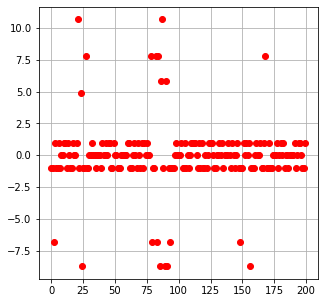

In [372]:
#Testing the learnt  Double Q-Learning Algorithm on Stochastic Environment for the Grid World problem
epsilon_array, reward_array , dict, alpha, gamma = model.fit(episodes=200, train=False,alpha= alpha, gamma=gamma)
plt.plot(dict['ep'], reward_array, "ro")
plt.grid()
plt.show()

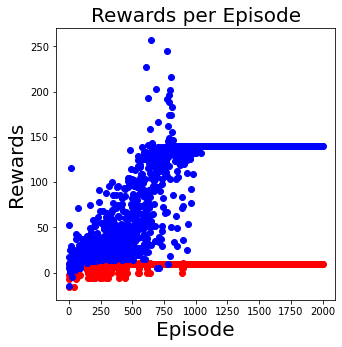

In [373]:
#Comparison graph for deterministic environment - Q Learning vs Double Q Learning
env = GridEnvironment(stochastic = False, max_timesteps = 1000)
model1 = DoubleQLearning(env)
epsilon_array, reward_array , dict, alpha, gamma = model1.fit(episodes=2000,alpha = 0.15, gamma= 0.92)
rewards1, episodes1 = reward_array, dict['ep']
plt.plot(episodes1, rewards1,"ro", label="total rewards per episode")
model2 = QLearning(env)
epsilon_array, reward_array , dict, alpha, gamma = model2.fit(episodes=2000,alpha = 0.15, gamma= 0.92)
rewards1, episodes1 = reward_array, dict['ep']
plt.plot(episodes1, rewards1,"bo", label="total rewards per episode")
plt.xlabel('Episode',fontsize=20)
plt.ylabel('Rewards',fontsize=20)
plt.title("Rewards per Episode",fontsize=20)
plt.show()


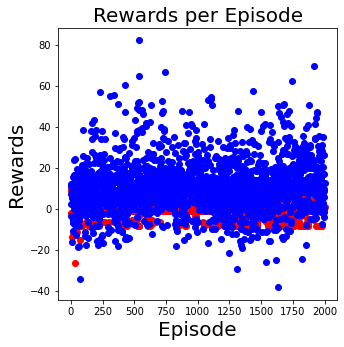

In [374]:
#Comparison graph for stochastic environment - Q Learning vs Double Q Learning
env = GridEnvironment(stochastic = True, max_timesteps = 1000)
model1 = DoubleQLearning(env)
epsilon_array, reward_array , dict, alpha, gamma = model1.fit(episodes=2000,alpha = 0.15, gamma= 0.92)
rewards1, episodes1 = reward_array, dict['ep']
plt.plot(episodes1, rewards1,"ro", label="total rewards per episode")
model2 = QLearning(env)
epsilon_array, reward_array , dict, alpha, gamma = model2.fit(episodes=2000,alpha = 0.15, gamma= 0.92)
rewards1, episodes1 = reward_array, dict['ep']
plt.plot(episodes1, rewards1,"bo", label="total rewards per episode")
plt.xlabel('Episode',fontsize=20)
plt.ylabel('Rewards',fontsize=20)
plt.title("Rewards per Episode",fontsize=20)
plt.show()


In [375]:
import gymnasium
from gymnasium import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [376]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gymnasium.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path
        self.stock_data = pd.read_csv(self.file_path)
        self.train = train

        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

        self.observation_space = spaces.Discrete(4)
        self.action_space = spaces.Discrete(3)

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.

                 info: - info: - A dictionary that can be used to provide additional implementation information."""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector that will be passed to the agent.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector.
            observation = [price_increase, stock_held]

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        info = None

        return observation, info

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - Integer in the range 0 to 2 inclusive.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.
                 reward: - Integer/Float value that's used to measure the performance of the agent.
                 terminated: - Boolean describing whether the episode has terminated.
                 truncated: - Boolean describing whether a truncation condition outside the scope of the MDP is satisfied.
                 info: - A dictionary that can be used to provide additional implementation information."""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = True
        else:
            stock_held = False

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the maximum timesteps have been reached.
        terminated = True if (self.timestep >= self.max_timesteps) \
            else False
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

In [377]:
# NOTE: You can adjust the parameter 'number_of_days_to_consider'
stock_trading_environment = StockTradingEnvironment('/content/NVDA (1).csv', number_of_days_to_consider=100)


In [378]:
model = QLearning(stock_trading_environment)
alpha = np.random.uniform(0.1,0.2)
gamma = np.random.uniform(0.9,0.99)
epsilon_array, reward_array , dict,alpha, gamma = model.fit(episodes=1000,alpha=alpha,gamma=gamma)

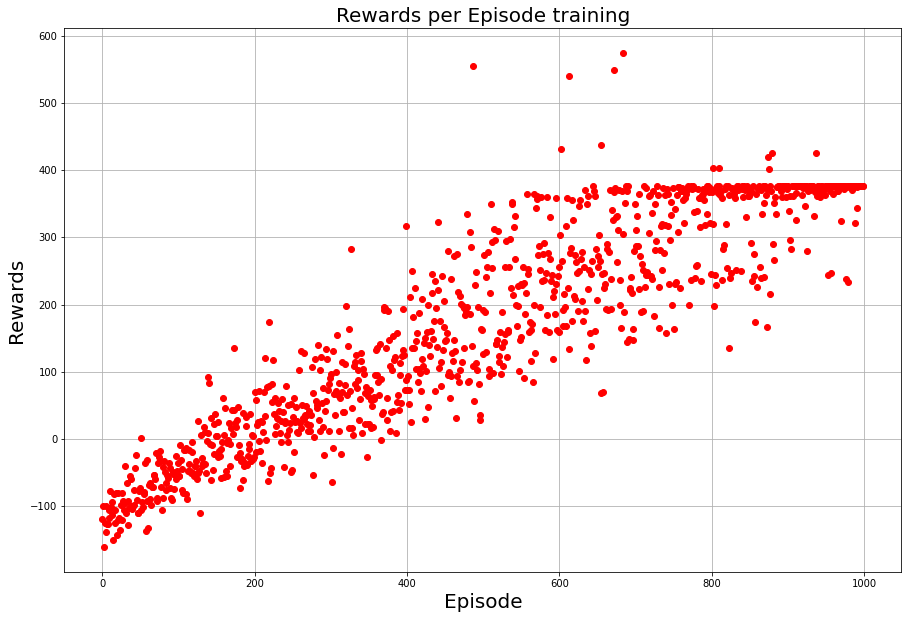

In [379]:
episodes,rewards = dict['ep'],reward_array
plt.figure(figsize=(15,10))
plt.plot(episodes,rewards, 'ro')
plt.xlabel('Episode',fontsize=20)
plt.ylabel('Rewards',fontsize=20)
plt.title("Rewards per Episode training",fontsize=20)
plt.grid()
plt.show()

Text(0.5, 1.0, 'Epsilon decay per Episode training')

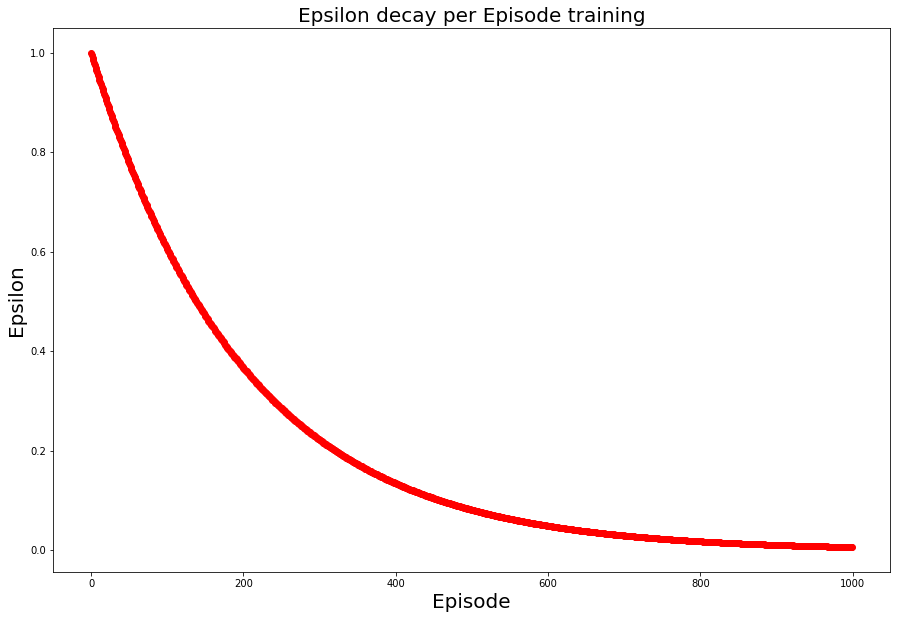

In [380]:
epsilon,rewards = epsilon_array,reward_array
plt.figure(figsize=(15,10))
plt.plot(episodes,epsilon, 'ro')
plt.xlabel('Episode',fontsize=20)
plt.ylabel('Epsilon',fontsize=20)
plt.title("Epsilon decay per Episode training",fontsize=20)

In [381]:
stock_trading_environment = StockTradingEnvironment('/content/NVDA (1).csv', train=False)
model = QLearning(stock_trading_environment)
alpha = np.random.uniform(0.1,0.2)
gamma = np.random.uniform(0.9,0.99)
epsilon_array, reward_array , dict, alpha, gamma = model.fit(episodes=200, train= False,alpha=alpha,gamma=gamma)

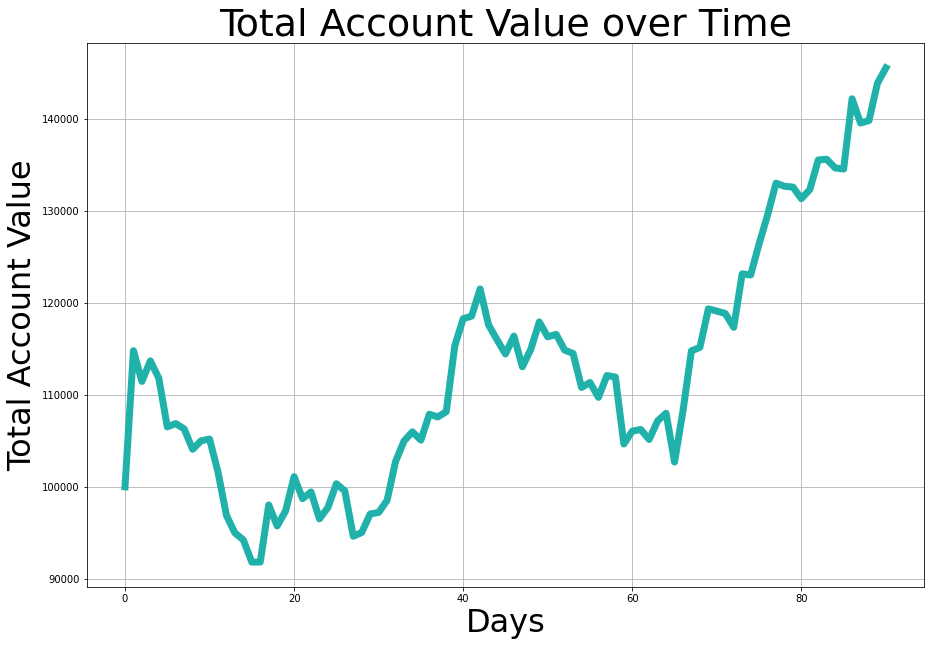

In [382]:
stock_trading_environment.render()